## Import Libraries and model

In [1]:
import tensorflow as tf
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model
import numpy as np
import matplotlib.pyplot as plt


In [2]:
model = VGG19(
    include_top = False,
    weights="imagenet"
)

model.trainable = False
model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

## Preprocessing

In [3]:
def load_and_process_image(image_path):
    """
    Arguments: image present at a specified path.
    Returns: np array of the image with shape (samples, size1, size2, channels).
    """
    img = load_img(image_path)
    img = img_to_array(img)
    img = preprocess_input(img)
    img = np.expand_dims(img, axis=0)
    return img
    

In [4]:
def deprocess(x):
    """
    Arguments: np array of the image
    Returns: De-normalise image where displaying image can be possible.
    """
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

def display_image(image):
    """
    Arguments: np array of the image
    Returns: Displays the image
    """
    if len(image.shape)==4:
        img = np.squeeze(image, axis=0)
    img = deprocess(img)
    
    #to display the image
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img)
    return 

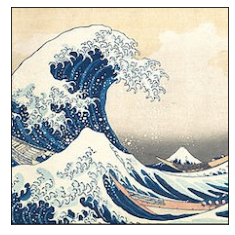

In [5]:
display_image(load_and_process_image("style.jpg"))

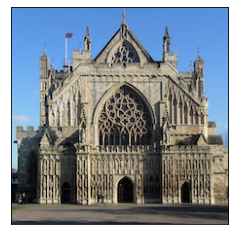

In [6]:
display_image(load_and_process_image("content.jpg"))

## Content and Style models

In [7]:
content_layer='block5_conv2'
style_layers=[
    'block1_conv1',
    'block3_conv1',
    'block5_conv1'
]

In [8]:
content_model = Model(
    inputs = model.input,
    outputs = model.get_layer(content_layer).output
)

style_models = [Model(
    inputs = model.input,
    outputs = model.get_layer(layer).output) for layer in style_layers]

In [9]:
def content_cost(content, generated):
    a_C = content_model(content)
    a_G = content_model(generated)
    cost = tf.reduce_mean(tf.square(a_C - a_G))
    return cost

In [10]:
def gram_matrix(A):
    n_C = int(A.shape[-1])
    a = tf.reshape(A, [-1, n_C])
    n = tf.shape(a)[0]
    G = tf.matmul(a, a, transpose_a=True)
    return G/tf.cast(n, tf.float32)

In [11]:
#weights of the layer 
lam = 1./len(style_models)
def style_cost(style, generated):
    J_style = 0
    
    for style_model in style_models:
        a_S = style_model(style)
        a_G = style_model(generated)
        GS = gram_matrix(a_S)
        GG = gram_matrix(a_G)
        current_cost = tf.reduce_mean(tf.square(GS-GG))
        J_style += current_cost * lam
    return J_style

## Training loop

In [12]:
import time
generated_images=[]
def training_loop(content_path, style_path, iterations=20, alpha=10., beta=20.):
    content = load_and_process_image(content_path)
    style = load_and_process_image(style_path)
    
    generated = tf.Variable(content, dtype=tf.float32)
    opt = tf.keras.optimizers.Adam(learning_rate=7.)
    
    best_cost = 1e12 + 0.1
    best_image = None
    
    start_time = time.time()
    
    for i in range(iterations):
        with tf.GradientTape() as tape: 
            J_content = content_cost(content, generated)
            J_style = style_cost(style, generated)
            J_total = alpha * J_content + beta * J_style
    
        grads = tape.gradient(J_total, generated)
        opt.apply_gradients([(grads, generated)])
    
        if J_total < best_cost:
            best_cost = J_total
            best_image = generated.numpy()

        print('Cost at {}: {}. Time elapsed: {}'.format(i, J_total, time.time() - start_time))
        generated_images.append(generated.numpy())
    return best_image

In [13]:
best_image = training_loop('content.jpg', 'style.jpg')

Cost at 0: 13733986304.0. Time elapsed: 11.066612243652344
Cost at 1: 8505728512.0. Time elapsed: 21.803735494613647
Cost at 2: 5336611840.0. Time elapsed: 32.17553353309631
Cost at 3: 4128448768.0. Time elapsed: 42.46925354003906
Cost at 4: 3317499136.0. Time elapsed: 52.28445363044739
Cost at 5: 2789864192.0. Time elapsed: 62.036282539367676
Cost at 6: 2499667200.0. Time elapsed: 71.26632857322693
Cost at 7: 2264962816.0. Time elapsed: 80.72666192054749
Cost at 8: 2034289152.0. Time elapsed: 89.85202026367188
Cost at 9: 1824829568.0. Time elapsed: 98.84799480438232
Cost at 10: 1641277056.0. Time elapsed: 108.1390426158905
Cost at 11: 1471980544.0. Time elapsed: 117.1287260055542
Cost at 12: 1319641472.0. Time elapsed: 126.25073623657227
Cost at 13: 1195698304.0. Time elapsed: 135.32477164268494
Cost at 14: 1100299520.0. Time elapsed: 144.28469514846802
Cost at 15: 1022350592.0. Time elapsed: 153.4672200679779
Cost at 16: 955063616.0. Time elapsed: 162.59728574752808
Cost at 17: 89369

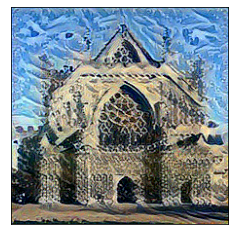

In [14]:
display_image(best_image)

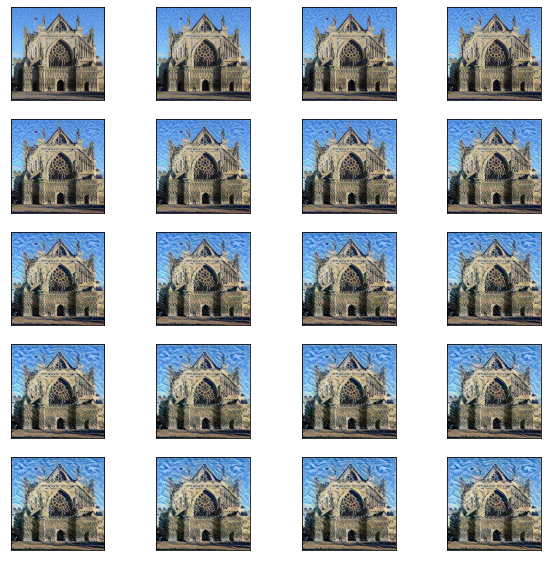

In [15]:
plt.figure(figsize=(10,10))

for i in range(20):
    plt.subplot(5, 4, i+1)
    display_image(generated_images[i])
plt.show()